# The dispersive regime of the Jaynes Cummings model

In this Assignment we will investigate the dispersive approximation to the JC model in more detail. The assignment consists of 2 parts: Part I is an analytical derivation \& Part II is a numerical exercise using Qutip.

## Part I : Analytical question (10 marks)

Consider the Jaynes-Cumming Hamiltonian

$$
H/\hbar = \omega_r a^\dagger a + \frac{\omega_a}{2} \sigma_z + g(a \sigma_+ + a^\dagger \sigma_-).
$$

Let $U^\dagger=\exp\left[-\alpha a^\dagger \sigma_- + \alpha a \sigma_+\right]$ with $\alpha = g/\Delta$, $\Delta = \omega_a - \omega_r$. 

Use the Baker-Campbell-Hausdorff formula

$$
    e^{S} H e^{-S} = H + [S, H] + \frac12 [S, [S, H]] + \dots,
$$

to derive the dispersive approximation

$$
U^\dagger H U / \hbar \simeq \omega_r a^\dagger a + \frac{\omega_a + \chi}{2} \sigma_z + \chi a^\dagger a \sigma_z + \text{const.},
$$

where $\chi = g^2/\Delta$ and the last constant term is unimportant.


Hint: To arrive at the correct form, terms multiplied with $\omega_r$ and $\omega_a$ need to be expanded to second order in $\alpha$, while terms multiplied by $g$ can be expanded only to first order.

Insert your solution below.

## Part II : Numerical question (10 marks)

### * The Assignment task follows an introduction and an example *

Having derived the dispersive approximation to the JC model we will further simplify by neglecting the Lamb shift, 

$$
H = \omega_r a^{\dagger} a + \frac{\omega_a}{2} \sigma_z + \chi a^\dagger a \sigma_z ,
$$

We will also include the effect of energy loss with decay rates

$$
\kappa,\gamma,
$$

for the cavity and the qubit, respectively.

In contrast to Notebook 1, where the focus was on time-dynamics, we will here mostly focus on the _steady_ _state_ and do a "numerical experiment" mimicking the experiment by Schuster et al.

### Setting up the problem

To model the experiment, we need to include the effect of the two drives: The cavity drive close to $\omega_\text{rf} \simeq \omega_r + |\chi|$, and a spectroscopy drive with frequency $\omega_s$ that we will sweep. The effect of the drives can be modelled by a Hamiltonian

$$
H = \omega_r a^{\dagger} a + \frac{\omega_a}{2} \sigma_z + \chi a^\dagger a \sigma_z
+ \varepsilon_\text{rf} ( a e^{i \omega_\text{rf} t} + a^\dagger e^{-i\omega_\text{rf} t} )
+ \varepsilon_{s} ( \sigma_- e^{i \omega_{s} t} + \sigma_+ e^{-i\omega_{s} t} )
$$

It is practical when working with this Hamiltonian to first go to a "rotating frame" by doing a unitary transformation defined by

$$
U = \exp\left[-i(\omega_\text{rf} a^\dagger a + \omega_s \sigma_z/2)t\right]
$$

It is not too hard to show that

$$
\begin{align}
H_U &= U^\dagger H U - i U^\dagger \dot U \\
&= \delta_r a^{\dagger} a + \frac{\delta_a}{2} \sigma_z + \chi a^\dagger a \sigma_z
+ \varepsilon_\text{rf} ( a  + a^\dagger )
+ \varepsilon_{s} ( \sigma_-  + \sigma_+ )
\end{align},
$$

where $\delta_r = \omega_r - \omega_\text{rf}$ and $\delta_a = \omega_a - \omega_s$.
The advantage of this change of frame is that $H_U$ is time-independent, which is very convenient when doing numerics. Varying the drive frequencies is now just a question of varying the parameters $\delta_r$ and $\delta_a$.

### Finding steady states in QuTiP

The system's steady state in the presense of energy decay can be found using the `steadystate` function. This function takes two mandatory arguments:

```
rho = qt.steadystate(H, c_ops)
```

where `H` is the Hamiltonian QuTiP object, and `c_ops = [a, b, c, ...]` is a list of operators that describe the energy decay. These operators have the following form

$$
\sqrt{\Gamma} O,
$$

where $\Gamma$ is the decay rate, and $O$ is the operator describing loss of energy quanta. In our case, we will include both loss of cavity photons and spontaneous emission of photons from the qubit, which can be described by two operators

$$
\sqrt{\kappa} a, \sqrt{\gamma} \sigma_-,
$$

respectively.

Note that `qt.steadystate` returns a _density_ _matrix_ $\rho$. A density matrix generalizes the notion of quantum states to include statistical mixtures. More precisely, any density matrix can be written

$$
\rho = \sum_k p_k |\psi_k\rangle\langle\psi_k|,
$$

where $p_k$ is a probability distribution, $p_k\ge 0, \sum_k p_k = 1$, and $|\psi_k\rangle$ an arbitrary set of states.

The expectation value of any operator is given by
$$
\langle X \rangle = \text{tr}[X\rho] = \sum_k p_k \text{tr}\left[X|\psi_k\rangle\langle\psi_k|\right]
= \sum_k p_k \langle \psi_k|X|\psi_k\rangle,
$$
hence the interpretation as a mixture / probability distribution over the states $|\psi_k\rangle$. See Chapters 2 and 8 of "Quantum Computation and Quantum Information" by Nielsen and Chuang to learn more about the density matrix formalism.

As usual, expectation values can be computed using QuTiP's `expect(O, rho)`.

### Example:

Here is a simple example illustrating how to use the `steadystate` function. We will investigate the qubit-state dependent transmission through the cavity. We do not need the spectroscopy drive on the qubit in this example and therefore set $\varepsilon_s = 0$, $\omega_s = 0$.

Due to a non-zero qubit decay rate $\gamma > 0$, the qubit's steady state will be the ground state $|g\rangle$. For this reason, we expect a peak in the intracavity photon number $\langle a^\dagger a \rangle$ if

$$
\omega_\text{rf} = \omega_r - \chi.
$$

To see how this changes if the qubit is in the excited state, we will subsequently artificially change the qubit decay operator to be $\sqrt{\gamma}\sigma_+$, such that the qubit steady state is $|e\rangle$. In an experiment we could achieve this by by preparing the qubit in the exited state before the experiment, given that the decay rate is sufficiently low.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

# use inline plotting
%matplotlib inline

In [3]:
nmax = 10
idr = qt.identity(nmax)
ida = qt.identity(2)
    
ground = qt.basis(2, 1)
excited = qt.basis(2, 0)
    
a = qt.tensor(qt.destroy(nmax), ida) 
sz = qt.tensor(idr, qt.sigmaz())
sm = qt.tensor(idr, qt.sigmam())
sp = qt.tensor(idr, qt.sigmap())
 
chi = -5 # units of 2pi MHz
deltar = chi
epsrf = 0.1
kappa = 0.1
gamma = 0.1

deltar_range = np.linspace(2 * chi, - 2 * chi, 500)
photons_g = []
photons_e = []

# scan over deltar and compute <a* a>
for deltar in deltar_range:
    # HU includes a drive on the resonator with strength epsrf and detuning deltar
    # we drop the drive qubit drive in this example as it is not needed
    # the qubit frequency wa is irrelevant, so we set it to zero
    HU = (deltar * a.dag() * a + 0 * sz / 2 + chi * a.dag() * a * sz
          + epsrf * (a + a.dag()))
    
    # find steady state with atom in ground state
    c_ops = [np.sqrt(kappa) * a, np.sqrt(gamma) * sm]
    rho = qt.steadystate(HU, c_ops)
    n_g = qt.expect(a.dag() * a, rho)
    photons_g.append(n_g)
    
    # find steady state with atom in exited state
    c_ops = [np.sqrt(kappa) * a, np.sqrt(gamma) * sp]
    rho = qt.steadystate(HU, c_ops)
    n_e = qt.expect(a.dag() * a, rho)    
    photons_e.append(n_e)

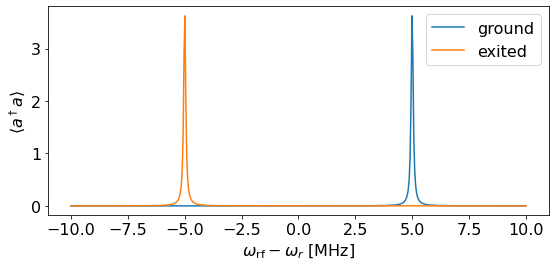

In [4]:
# plot result
# note that deltar = wr - wrf < 0 means that the drive is _above_ wr

fig = plt.figure(figsize=(8, 4))
plt.rc('font', size=16)

# plot vs. -deltar for clarity
plt.plot(-deltar_range, photons_g)
plt.plot(-deltar_range, photons_e)

plt.xlabel(r'$\omega_{\rm rf} - \omega_r$ [MHz]')
plt.ylabel(r'$\langle a^\dagger a \rangle$')
plt.legend(['ground', 'exited'])

fig.tight_layout()

###  Assignment task

In this exercise you will investigate the physics behind Figs. 3 and 4 in the paper by Schuster et al in terms of a numerical experiment.

The key to the experiment is that the "effective" qubit frequency depends on how many photons $n$ there are in the cavity

$$
\omega_a + 2 n \chi
$$

Therefore, if we drive the qubit with a tone at frequency $\omega_s$, we expect to see an increase in the qubit population whenever $\omega_s$ hits one of these resonances, for $n=0,1,2,\dots$.

Due to damping, the cavity will simply be in the vacuum state with $n=0$, unless we provide some energy input. This is done by including the cavity drive with strength $\varepsilon_\text{rf}$ at a frequency $\omega_\text{rf} = \omega_r - \chi$ (the resonance frequency if the qubit is in the ground state).

Here is what you should do:

Produce a plot of the qubit excited state population

$$
\langle P_e \rangle
$$

with $P_e = |e\rangle\langle e| = \frac12 (\sigma_z + I)$, as a function of $\delta_a$ for the following parameters:

$$
\begin{align}
\delta_r &= \omega_r - \omega_\text{rf} = \chi,\\
\chi/(2\pi) &= -5 \text{ MHz},\\
\varepsilon_\text{rf}/(2\pi) &= 0.1 \text{ MHz},\\
\varepsilon_s/(2\pi) &= 0.05 \text{ MHz},\\
\kappa/(2\pi) & = \gamma/(2\pi) = 0.1 \text{ MHz},\\
\end{align}
$$

Insert your solution below.